## Text Mining - TP Stocks

### Librerias

In [251]:
import pandas as pd
import nltk
nltk.download('stopwords')
import spacy
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ferna\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Archivo entrenamiento

In [54]:
#data = pd.read_excel('C:/Users/ferna/Downloads/ypf PAGINAS v4.xlsx', sheet_name= 'UNIFICADO')
#data = pd.read_excel('C:/Users/ferna/Downloads/ypf_v5_binario.xlsx', sheet_name= 'UNIFICADO')
data = pd.read_excel('C:/Users/ferna/Downloads/ypf_v6.xlsx', sheet_name= 'UNIFICADO')

### Stopwords

In [3]:
stopwords_en = set(stopwords.words('english'))

In [4]:
word_count = {}

for sentence in data[data['Category'].isin(['Compra'])]['Text'].to_list():
    words = sentence.split()
    
    for word in words:
        word = word.strip(".,!?()").lower()
        
        if word in word_count:
            word_count[word] += 1
        else:
            word_count[word] = 1

In [5]:
word_count_filtro = {word: count for word, count in word_count.items() if word not in stopwords_en}

In [6]:
word_counts_orden = dict(sorted(word_count_filtro.items(), key=lambda x: x[1], reverse=True))

In [7]:
df = pd.DataFrame(list(word_counts_orden.items()), columns=['Palabra', 'Frecuencia'])

file_path = 'stopwords_pos_orden.xlsx'

df.to_excel(file_path, index=False)

In [8]:
# Listado de stopwords propio
stopwords_personales = ['Refinitiv','Zacks','Rystad','Andrew','Rocco','Nilanjan','Benerjee','CERAWEEK','Tirthankar','Chakraborty','Anindya','Barman','Scott','Squires','Jonathan','Gilbert','Yvonne','Yue','Li'
                        'Laura','Millan','Jorgelina','Do','Rosario']

stopwords_personales = [x.lower() for x in stopwords_personales]

stopwords_custom = stopwords_en.union(stopwords_personales)

### Power Words

In [9]:
column1_values = data['Power Word 01'].tolist()
column2_values = data['Power Word 02'].tolist()
column3_values = data['Power Word 03'].tolist()
column4_values = data['Power Word 04'].tolist()
column5_values = data['Power Word 05'].tolist()
column6_values = data['Power Word 06'].tolist()
column7_values = data['Power Word 07'].tolist()
column8_values = data['Power Word 08'].tolist()

In [10]:
combined_values = set(
    column1_values + 
    column2_values + 
    column3_values + 
    column4_values + 
    column5_values + 
    column6_values + 
    column7_values + 
    column8_values
    )

In [11]:
unique_values_list = list(combined_values)
unique_values_list = [value for value in unique_values_list if pd.notna(value)]
powerWords = [str(value).lower() for value in unique_values_list]

### Lematización

In [12]:
def func_lemma(X_train, dicc_stopwords):
    
    nlp = spacy.load("en_core_web_sm")
    
    X_train_lemma = []

    for noticia in X_train:
        l_doc = nlp(noticia)
        v_lema = " ".join([token.lemma_.lower() for token in l_doc if token.text.lower() not in dicc_stopwords and not token.is_punct])
        X_train_lemma.append(v_lema)

    return X_train_lemma

### Split Train / Test

In [136]:
data_train = data[data['Train/Test'].isin(['Train'])]
data_test = data[data['Train/Test'].isin(['Test'])]

In [138]:
X_train = data_train['Text'].tolist()
y_train = data_train['Category'].tolist()

In [139]:
X_test = data_test['Text'].tolist()
y_test = data_test['Category'].tolist()

## Lemma (Similitud del Coseno y Jaccard)

In [16]:
from sklearn.metrics.pairwise import cosine_similarity
#from sklearn.metrics import jaccard_score

list1 = X_train
list2 = func_lemma(X_train, stopwords_custom)
vectorizer = CountVectorizer()

data = []

for str1, str2 in zip(list1, list2):
    tokens1 = str1.split()
    tokens2 = str2.split()

    matrix1 = vectorizer.fit_transform([" ".join(tokens1)])
    matrix2 = vectorizer.transform([" ".join(tokens2)])
    
    cosine_sim = cosine_similarity(matrix1, matrix2)[0][0]

    #jaccard_sim = len(set(tokens1) & set(tokens2)) / len(set(tokens1) | set(tokens2))

    data.append([str1, str2, cosine_sim])

df = pd.DataFrame(data, columns=["Original", "Lemma", "Coseno"])

In [18]:
#df[df['Coseno']<=0.7].count()

df

,Original,Lemma,Coseno
0,\nYPF Sociedad Anonima (YPF) Gains But Lags M...,\n ypf sociedad anonima ypf gain lags market ...,0.823387
1,YPF Sociedad Anonima (YPF) Gains But Lags Mark...,ypf sociedad anonima ypf gain lags market know,0.801784
2,15 Cheap Growth Stocks to Buy —,15 cheap growth stock buy,0.816497
3,\nYPF Sociedad Anonima (YPF) Outpaces Stock M...,\n ypf sociedad anonima ypf outpaces stock ma...,0.858898
4,\nAre Investors Undervaluing YPF Sociedad Ano...,\n investor undervalue ypf sociedad anonima y...,0.797724
...,...,...,...
218,Bitesize Podcast: Argentina's YPF Faces First ...,bitesize podcast argentina 's ypf face first l...,0.957427
219,YPF Stuns Bondholders as Argentina Runs Out of...,ypf stuns bondholders argentina runs dollars \...,0.571241
220,"Oaktree, BlackRock Are Said to Be Among YPF Cr...",oaktree blackrock say among ypf creditor organ...,0.649655
221,"Crop U-Turn in Argentina Ruffles Importers, La...",crop u turn argentina ruffles importers lays b...,0.771517


In [20]:
def remove_stopwords(tokens):
    filtered_tokens = [word for word in tokens if word.lower() not in stopwords_custom]
    return filtered_tokens

original_text = " ".join(list1)
lemmatized_text = " ".join(list2)

original_tokens = original_text.split()
lemmatized_tokens = lemmatized_text.split()

filtered_original_tokens = remove_stopwords(original_tokens)
filtered_lemmatized_tokens = remove_stopwords(lemmatized_tokens)

original_unique_words = set(filtered_original_tokens)
lemmatized_unique_words = set(filtered_lemmatized_tokens)

total_unique_words_original = len(original_unique_words)
total_unique_words_lemmatized = len(lemmatized_unique_words)

print(f"Diccionario original: {total_unique_words_original}")
print(f"Diccionario lemma: {total_unique_words_lemmatized}")

Diccionario original: 1710
Diccionario lemma: 1252


## Regresión Logistica

### Pipeline

In [21]:
clf_lr = Pipeline([
    ('vect' , CountVectorizer()), 
    ('tfidf', TfidfTransformer()), 
    ('clf'  , LogisticRegression())
])

clf_lr_sw = Pipeline([
    ('vect' , CountVectorizer(stop_words=stopwords_custom)), 
    ('tfidf', TfidfTransformer()), 
    ('clf'  , LogisticRegression())
])

### Entrenamiento

In [22]:
clf_lr = clf_lr.fit(X_train, y_train)

clf_lr_sw = clf_lr_sw.fit(X_train, y_train)

clf_lr_lema = clf_lr.fit(func_lemma(X_train,stopwords_custom), y_train)

### Predicción ( Etiquetas )

In [23]:
y_pred_lr = clf_lr.predict(X_test)

y_pred_lr_sw = clf_lr_sw.predict(X_test)

y_pred_lr_lema = clf_lr_lema.predict(X_test)

### Predicción ( Probabilidad )

In [24]:
y_pred_lr_proba = clf_lr.predict_proba(X_test)

y_pred_lr_sw_proba = clf_lr_sw.predict_proba(X_test)

y_pred_lr_lema_proba = clf_lr_lema.predict_proba(X_test)

### Evaluación

In [26]:
print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred_lr_sw) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(y_test, y_pred_lr_sw, average='weighted') * 100))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_lr_sw))

Accuracy: 69.05%

F1 Score: 68.99

Confusion Matrix:
 [[32 12]
 [14 26]]


## Naive Bayes Multinomial

### Pipeline

In [27]:
clf_nb = Pipeline([
    ('vect' , CountVectorizer()), 
    ('tfidf', TfidfTransformer()), 
    ('clf'  , MultinomialNB())
])

clf_nb_sw = Pipeline([
    ('vect' , CountVectorizer(stop_words=stopwords_custom)), 
    ('tfidf', TfidfTransformer()), 
    ('clf'  , MultinomialNB())
])

### Entrenamiento

In [28]:
clf_nb = clf_nb.fit(X_train, y_train)

clf_nb_sw = clf_nb_sw.fit(X_train, y_train)

clf_nb_lema = clf_nb.fit(func_lemma(X_train,stopwords_custom), y_train)

### Predicción ( Etiquetas )

In [29]:
y_pred_nb = clf_nb.predict(X_test)

y_pred_nb_sw = clf_nb_sw.predict(X_test)

y_pred_nb_lema = clf_nb_lema.predict(X_test)

### Predicción ( Probabilidad )

In [30]:
y_pred_nb_proba = clf_nb.predict_proba(X_test)

y_pred_nb_sw_proba = clf_nb_sw.predict_proba(X_test)

y_pred_nb_lema_proba = clf_nb_lema.predict_proba(X_test)

In [31]:
print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred_nb) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(y_test, y_pred_nb, average='weighted') * 100))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_nb))

Accuracy: 64.29%

F1 Score: 62.95

Confusion Matrix:
 [[36  8]
 [22 18]]


In [32]:
print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred_nb_sw) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(y_test, y_pred_nb_sw, average='weighted') * 100))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_nb_sw))

Accuracy: 66.67%

F1 Score: 64.66

Confusion Matrix:
 [[39  5]
 [23 17]]


In [33]:
print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred_nb_lema) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(y_test, y_pred_nb_lema, average='weighted') * 100))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_nb_lema))

Accuracy: 64.29%

F1 Score: 62.95

Confusion Matrix:
 [[36  8]
 [22 18]]


## Support Vector Classifier

### Pipeline

In [34]:
clf_svc = Pipeline([
    ('vect' , CountVectorizer()), 
    ('tfidf', TfidfTransformer()), 
    ('clf'  , LinearSVC())
])

clf_svc_sw = Pipeline([
    ('vect' , CountVectorizer(stop_words=stopwords_custom)), 
    ('tfidf', TfidfTransformer()), 
    ('clf'  , LinearSVC())
])

clf_svc_proba = Pipeline([
    ('vect' , CountVectorizer()), 
    ('tfidf', TfidfTransformer()), 
    ('clf'  , CalibratedClassifierCV(LinearSVC()))
])

clf_svc_sw_proba = Pipeline([
    ('vect' , CountVectorizer(stop_words=stopwords_custom)), 
    ('tfidf', TfidfTransformer()), 
    ('clf'  , CalibratedClassifierCV(LinearSVC()))
])

### Entrenamiento

In [35]:
clf_svc = clf_svc.fit(X_train, y_train)

clf_svc_sw = clf_svc_sw.fit(X_train, y_train)

clf_svc_lema = clf_svc.fit(func_lemma(X_train,stopwords_custom), y_train)

### Predicción ( Etiquetas )

In [36]:
y_pred_svc = clf_svc.predict(X_test)

y_pred_svc_sw = clf_svc_sw.predict(X_test)

y_pred_svc_lema = clf_svc_lema.predict(X_test)

### Predicción ( Probabilidad )

In [37]:
clf_svc = clf_svc_proba.fit(X_train, y_train)

clf_svc_sw = clf_svc_sw_proba.fit(X_train, y_train)

clf_svc_lema = clf_svc_proba.fit(func_lemma(X_train,stopwords_custom), y_train)

In [38]:
y_pred_svc_proba = clf_svc.predict_proba(X_test)

y_pred_svc_sw_proba = clf_svc_sw.predict_proba(X_test)

y_pred_svc_lema_proba = clf_svc_lema.predict_proba(X_test)

In [39]:
print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred_svc) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(y_test, y_pred_svc, average='weighted') * 100))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_svc))

Accuracy: 64.29%

F1 Score: 64.22

Confusion Matrix:
 [[30 14]
 [16 24]]


In [40]:
print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred_svc_sw) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(y_test, y_pred_svc_sw, average='weighted') * 100))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_svc_sw))

Accuracy: 69.05%

F1 Score: 68.91

Confusion Matrix:
 [[33 11]
 [15 25]]


In [41]:
print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred_svc_lema) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(y_test, y_pred_svc_lema, average='weighted') * 100))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_svc_lema))

Accuracy: 64.29%

F1 Score: 64.22

Confusion Matrix:
 [[30 14]
 [16 24]]


## Random Forest

In [42]:
clf_rf = Pipeline([
    ('vect' , CountVectorizer()), 
    ('tfidf', TfidfTransformer()), 
    ('clf'  , RandomForestClassifier())
])

clf_rf_sw = Pipeline([
    ('vect' , CountVectorizer(stop_words=stopwords_custom)), 
    ('tfidf', TfidfTransformer()), 
    ('clf'  , RandomForestClassifier())
])

In [43]:
clf_rf = clf_rf.fit(X_train, y_train)

clf_rf_sw = clf_rf_sw.fit(X_train, y_train)

In [44]:
y_pred_rf = clf_rf.predict(X_test)

y_pred_rf_sw = clf_rf_sw.predict(X_test)

y_pred_rf_proba = clf_rf.predict_proba(X_test)

y_pred_rf_sw_proba = clf_rf_sw.predict_proba(X_test)

In [45]:
print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred_rf) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(y_test, y_pred_rf, average='weighted') * 100))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))

Accuracy: 69.05%

F1 Score: 69.05

Confusion Matrix:
 [[31 13]
 [13 27]]


## Mapeo etiquetas

In [166]:
y_train_gb = data_train["Category"].map({'Neutro': 1, 'Compra': 0}).to_list()
y_test_gb = data_test["Category"].map({'Neutro': 1, 'Compra': 0}).to_list()

In [167]:
def map_value(value):
    if value == 0:
        return "Compra"
    else:
        return "Neutro"

## XGBoost

In [168]:
clf_xgb = Pipeline([
    ('vect' , CountVectorizer()), 
    ('tfidf', TfidfTransformer()), 
    ('clf'  , XGBClassifier())
])

clf_xgb_sw = Pipeline([
    ('vect' , CountVectorizer(stop_words=stopwords_custom)), 
    ('tfidf', TfidfTransformer()), 
    ('clf'  , XGBClassifier())
])

In [169]:
clf_xgb = clf_xgb.fit(X_train, y_train_gb)

clf_xgb_sw = clf_xgb_sw.fit(X_train, y_train_gb)

In [170]:
y_pred_xgb = clf_xgb.predict(X_test)

y_pred_xgb_sw = clf_xgb_sw.predict(X_test)

y_pred_xgb_proba = clf_xgb.predict_proba(X_test)

y_pred_xgb_sw_proba = clf_xgb_sw.predict_proba(X_test)

In [171]:
print("Accuracy: {:.2f}%".format(accuracy_score(y_test_gb, y_pred_xgb_sw) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(y_test_gb, y_pred_xgb_sw, average='weighted') * 100))
print("\nConfusion Matrix:\n", confusion_matrix(y_test_gb, y_pred_xgb_sw))

Accuracy: 67.86%

F1 Score: 67.83

Confusion Matrix:
 [[31 13]
 [14 26]]


In [172]:
y_pred_xgb = [map_value(value) for value in y_pred_xgb]
y_pred_xgb_sw = [map_value(value) for value in y_pred_xgb_sw]

## LightGBM

In [173]:
clf_lgbm = Pipeline([
    ('vect' , CountVectorizer()), 
    ('tfidf', TfidfTransformer()), 
    ('clf'  , LGBMClassifier())
])

clf_lgbm_sw = Pipeline([
    ('vect' , CountVectorizer(stop_words=stopwords_custom)), 
    ('tfidf', TfidfTransformer()), 
    ('clf'  , LGBMClassifier())
])

In [174]:
clf_lgbm = clf_lgbm.fit(X_train, y_train_gb)

clf_lgbm_sw = clf_lgbm_sw.fit(X_train, y_train_gb)

[LightGBM] [Info] Number of positive: 104, number of negative: 119
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002732 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 886
[LightGBM] [Info] Number of data points in the train set: 223, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.466368 -> initscore=-0.134733
[LightGBM] [Info] Start training from score -0.134733
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

In [175]:
y_pred_lgbm = clf_lgbm.predict(X_test)

y_pred_lgbm_sw = clf_lgbm_sw.predict(X_test)

y_pred_lgbm_proba = clf_lgbm.predict_proba(X_test)

y_pred_lgbm_sw_proba = clf_lgbm_sw.predict_proba(X_test)

In [176]:
print("Accuracy: {:.2f}%".format(accuracy_score(y_test_gb, y_pred_lgbm_sw) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(y_test_gb, y_pred_lgbm_sw, average='weighted') * 100))
print("\nConfusion Matrix:\n", confusion_matrix(y_test_gb, y_pred_lgbm_sw))

Accuracy: 66.67%

F1 Score: 66.61

Confusion Matrix:
 [[31 13]
 [15 25]]


In [177]:
y_pred_lgbm = [map_value(value) for value in y_pred_lgbm]
y_pred_lgbm_sw = [map_value(value) for value in y_pred_lgbm_sw]

### Output

In [178]:
models_pred = pd.DataFrame(
    {
        'X_test': X_test,
        'y_test': y_test,
        'RegLog': y_pred_lr,
        'RegLog_SW': y_pred_lr_sw,
        'MultinomialNB': y_pred_nb,
        'MultinomialNB_SW': y_pred_nb_sw,
        'SVC': y_pred_svc,
        'SVC_SW': y_pred_svc_sw,
        'RF':y_pred_rf,
        'RF_SW': y_pred_rf_sw,
        'XGB': y_pred_xgb,
        'XGB_SW': y_pred_xgb_sw,
        'LightGBM': y_pred_lgbm,
        'LightGBM_SW': y_pred_lgbm_sw
    }
)

In [180]:
models_pred

,X_test,y_test,RegLog,RegLog_SW,MultinomialNB,MultinomialNB_SW,SVC,SVC_SW,RF,RF_SW,XGB,XGB_SW,LightGBM,LightGBM_SW
0,Vaca Muerta's Sweet Crude Attracts Global Ener...,Compra,Compra,Compra,Compra,Compra,Compra,Compra,Compra,Compra,Compra,Compra,Compra,Compra
1,Is YPF SA (YPF) a Smart Choice in Oil & Gas In...,Neutro,Compra,Compra,Compra,Compra,Compra,Compra,Neutro,Neutro,Compra,Neutro,Compra,Compra
2,Mexico's Pemex the biggest liquidity worry amo...,Neutro,Neutro,Neutro,Neutro,Neutro,Neutro,Neutro,Neutro,Neutro,Neutro,Neutro,Compra,Neutro
3,Argentina Fixes Oil at $56 a Barrel to Put Lid...,Neutro,Neutro,Compra,Neutro,Neutro,Neutro,Neutro,Compra,Neutro,Compra,Neutro,Compra,Compra
4,Argentina to freeze crude price at $56/bbl to ...,Neutro,Neutro,Neutro,Compra,Neutro,Neutro,Neutro,Compra,Compra,Compra,Compra,Compra,Compra
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,The 5 Latin American Countries With The Larges...,Compra,Compra,Neutro,Compra,Neutro,Neutro,Neutro,Neutro,Neutro,Neutro,Neutro,Compra,Neutro
80,\nYPF Sociedad Anonima (YPF) Dips More Than B...,Neutro,Compra,Compra,Compra,Compra,Compra,Compra,Compra,Compra,Compra,Compra,Compra,Compra
81,Could Argentina Replicate Brazil’s Offshore Oi...,Compra,Compra,Compra,Compra,Compra,Compra,Compra,Compra,Compra,Compra,Compra,Compra,Compra
82,\nIs Weatherford International (WFRD) Stock O...,Neutro,Neutro,Neutro,Neutro,Neutro,Neutro,Neutro,Neutro,Neutro,Neutro,Neutro,Neutro,Neutro


In [181]:
models_pred.to_excel('ypf_predicciones_modelos.xlsx', index=False)

## Word2Vec

In [254]:
import gensim.models.word2vec as w2v

In [255]:
data_w2v = data[['Text','Train/Test','Category']]

In [269]:
def preprocess_w2v(text):
    # Remove stopwords and apply simple_preprocess
    words = [word for word in w2v.utils.simple_preprocess(text) if word.lower() not in stopwords_custom]
    return ' '.join(words)

In [270]:
data_w2v['text_clean'] = data_w2v['Text'].apply(preprocess_w2v)
data_w2v.head()

C:\Users\ferna\AppData\Local\Temp\ipykernel_19424\373371960.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_w2v['text_clean'] = data_w2v['Text'].apply(preprocess_w2v)


,Text,Train/Test,Category,text_clean
0,Vaca Muerta's Sweet Crude Attracts Global Ener...,Test,Compra,vaca muerta sweet crude attracts global energy...
1,Is YPF SA (YPF) a Smart Choice in Oil & Gas In...,Test,Neutro,ypf sa ypf smart choice oil gas integrated wed...
2,Mexico's Pemex the biggest liquidity worry amo...,Test,Neutro,mexico pemex biggest liquidity worry among pee...
3,Argentina Fixes Oil at $56 a Barrel to Put Lid...,Test,Neutro,argentina fixes oil barrel put lid inflation
4,Argentina to freeze crude price at $56/bbl to ...,Test,Neutro,argentina freeze crude price bbl curb inflation


In [272]:
dataset_train = data_w2v[data_w2v['Train/Test'].isin(['Train'])]
dataset_test = data_w2v[data_w2v['Train/Test'].isin(['Test'])]

X_train = dataset_train['text_clean'].tolist()
y_train = dataset_train['Category'].tolist()

X_test = dataset_test['text_clean'].tolist()
y_test = dataset_test['Category'].tolist()

In [273]:
w2v_model = w2v.Word2Vec(X_train,
                        vector_size=100,
                        window=5,
                        min_count=2)

In [274]:
words = set( w2v_model.wv.index_to_key )

X_train_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])
                         for ls in X_train])

X_test_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])
                         for ls in X_test])

C:\Users\ferna\AppData\Local\Temp\ipykernel_19424\3022861056.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_train_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])
C:\Users\ferna\AppData\Local\Temp\ipykernel_19424\3022861056.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_test_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])


In [275]:
X_train_vect_avg = []
for v in X_train_vect:
    if v.size:
        X_train_vect_avg.append(v.mean(axis=0))
    else:
        X_train_vect_avg.append(np.zeros(100, dtype=float))
        
X_test_vect_avg = []
for v in X_test_vect:
    if v.size:
        X_test_vect_avg.append(v.mean(axis=0))
    else:
        X_test_vect_avg.append(np.zeros(100, dtype=float))

In [276]:
rf = RandomForestClassifier()
rf_model = rf.fit(X_train_vect_avg, y_train)

In [277]:
y_pred_w2v = rf_model.predict(X_test_vect_avg)

In [278]:
print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred_w2v) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(y_test, y_pred_w2v, average='weighted') * 100))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_w2v))

Accuracy: 55.95%

F1 Score: 54.54

Confusion Matrix:
 [[17 27]
 [10 30]]


## Word2Vec (2)

In [ ]:
import gensim

GoogleModel = gensim.models.KeyedVectors.load_word2vec_format('C:/Users/ferna/Downloads/GoogleNews-vectors-negative300.bin.gz', binary=True,)

In [307]:
corpus = data['Text'].values

vectorizer = CountVectorizer(stop_words=stopwords_custom)

X = vectorizer.fit_transform(corpus)

CountVectorizedData=pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
CountVectorizedData['Category'] = data['Category']
CountVectorizedData['Split'] = data['Train/Test']

print(CountVectorizedData.shape)

CountVectorizedData.head()

WordsVocab = CountVectorizedData.columns[:-2]

def FunctionText2Vec(inpTextData):
    X = vectorizer.transform(inpTextData)
    CountVecData=pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
    
    W2Vec_Data=pd.DataFrame()
    
    for i in range(CountVecData.shape[0]):

        Sentence = np.zeros(300)

        for word in WordsVocab[CountVecData.iloc[i , :]>=1]:
            if word in GoogleModel.key_to_index.keys():    
                Sentence=Sentence+GoogleModel[word]
        W2Vec_Data=W2Vec_Data.append(pd.DataFrame([Sentence]))
    return(W2Vec_Data)

(333, 1698)


In [325]:
W2Vec_Data = FunctionText2Vec(data['Text'])

C:\Users\ferna\AppData\Local\Temp\ipykernel_19424\2799358765.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  W2Vec_Data=W2Vec_Data.append(pd.DataFrame([Sentence]))
C:\Users\ferna\AppData\Local\Temp\ipykernel_19424\2799358765.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  W2Vec_Data=W2Vec_Data.append(pd.DataFrame([Sentence]))
C:\Users\ferna\AppData\Local\Temp\ipykernel_19424\2799358765.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  W2Vec_Data=W2Vec_Data.append(pd.DataFrame([Sentence]))
C:\Users\ferna\AppData\Local\Temp\ipykernel_19424\2799358765.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  W2Vec_Data=W2Vec_Data.a

In [326]:
# Adding the target variable
W2Vec_Data.reset_index(inplace=True, drop=True)
W2Vec_Data['Category'] = CountVectorizedData['Category']
W2Vec_Data['Split'] = CountVectorizedData['Split']

# Assigning to DataForML variable
DataForML=W2Vec_Data
DataForML

,0,1,2,3,4,5,6,7,8,9,...,292,293,294,295,296,297,298,299,Category,Split
0,-2.612555,2.180817,-1.901596,1.644066,-1.403992,-1.067413,-0.307095,-4.590302,2.898636,2.488464,...,-2.055801,0.468796,-0.720398,2.189514,1.395073,-1.224696,3.168865,0.697662,Compra,Test
1,-0.508713,0.286743,-0.364624,0.789124,-0.309082,-0.173096,-0.136915,-1.236511,0.088135,0.748535,...,-0.525635,0.188965,-0.358215,-0.001160,0.426758,-0.012695,0.228577,0.652832,Neutro,Test
2,-1.198853,0.419434,0.174988,1.057617,0.130371,-0.629639,-0.363281,-0.318420,1.475220,0.394287,...,-0.613571,-0.082520,-0.168777,0.079407,-0.608887,0.413452,-0.147217,0.217896,Neutro,Test
3,-0.383850,0.420654,-0.848045,1.532227,-0.171814,-0.470337,0.114746,-1.177734,0.987747,0.189453,...,0.282227,0.486572,-0.264526,-0.026611,0.344727,0.009125,0.493851,-0.514343,Neutro,Test
4,-0.804199,0.151947,-0.002197,1.969971,0.229736,-0.707275,-0.181442,-1.224335,1.526321,-0.257568,...,0.598938,0.256836,0.175415,0.811646,-0.064941,-0.156067,0.452118,-0.225708,Neutro,Test
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
328,-0.395264,-0.218018,-0.333374,0.566162,-0.039185,-0.017822,-0.126831,-0.508163,1.509720,0.551758,...,0.451538,0.445801,0.049438,0.282715,-0.964966,-0.007996,-0.302246,-0.191772,Neutro,Train
329,0.521179,3.576294,-0.840271,2.756531,-0.318878,-1.422962,-0.738220,-4.835449,4.320343,1.637817,...,-3.883850,0.669556,-1.292068,1.516602,-2.763733,0.919098,2.354431,0.460266,Compra,Train
330,-0.506256,1.399048,-0.139923,1.187988,0.985992,-0.651932,0.527161,-1.870514,2.762037,0.674011,...,-2.046478,1.026718,0.534546,1.308350,0.417847,0.715240,0.165283,-0.604919,Neutro,Train
331,0.462173,1.174133,-0.854599,3.259815,0.027222,-1.480225,-0.077595,-2.732178,1.316330,3.248169,...,-1.841553,0.503105,0.040226,0.099289,-0.667847,-0.017151,2.397980,0.920532,Neutro,Train


In [349]:
# Separate Target Variable and Predictor Variables
TargetVariable = DataForML.columns[-2]
Predictors = DataForML.columns[:-2]

X = DataForML[Predictors].values
y = DataForML[TargetVariable].values

# Create boolean masks for Train and Test splits
train_mask = DataForML['Split'] == 'Train'
test_mask = DataForML['Split'] == 'Test'

# Extract the training and testing data
X_train = DataForML[train_mask][Predictors].values
y_train = DataForML[train_mask][TargetVariable].values
X_test = DataForML[test_mask][Predictors].values
y_test = DataForML[test_mask][TargetVariable].values

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(223, 300)
(223,)
(84, 300)
(84,)


In [350]:
# Naive Bayes
from sklearn.naive_bayes import GaussianNB, MultinomialNB

# GaussianNB is used in Binomial Classification
# MultinomialNB is used in multi-class classification
#clf = GaussianNB()
clf = MultinomialNB()

NB=clf.fit(X_train,y_train)
prediction=NB.predict(X_test)

# Measuring accuracy on Testing Data
from sklearn import metrics
print(metrics.classification_report(y_test, prediction))
print(metrics.confusion_matrix(y_test, prediction))

# Printing the Overall Accuracy of the model
F1_Score=metrics.f1_score(y_test, prediction, average='weighted')
print('Accuracy of the model on Testing Sample Data:', round(F1_Score,2))

# Importing cross validation function from sklearn
from sklearn.model_selection import cross_val_score

# Running 10-Fold Cross validation on a given algorithm
# Passing full data X and y because the K-fold will split the data and automatically choose train/test
Accuracy_Values=cross_val_score(NB, X , y, cv=5, scoring='f1_weighted')
print('\nAccuracy values for 5-fold Cross Validation:\n',Accuracy_Values)
print('\nFinal Average Accuracy of the model:', round(Accuracy_Values.mean(),2))

              precision    recall  f1-score   support

      Compra       0.56      0.41      0.47        44
      Neutro       0.50      0.65      0.57        40

    accuracy                           0.52        84
   macro avg       0.53      0.53      0.52        84
weighted avg       0.53      0.52      0.52        84

[[18 26]
 [14 26]]
Accuracy of the model on Testing Sample Data: 0.52

Accuracy values for 5-fold Cross Validation:
 [nan nan nan nan nan]

Final Average Accuracy of the model: nan


c:\Users\ferna\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\ferna\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\ferna\anaconda3\lib\site-packages\sklearn\naive_bayes.py", line 690, in fit
    self._count(X, Y)
  File "c:\Users\ferna\anaconda3\lib\site-packages\sklearn\naive_bayes.py", line 863, in _count
    check_non_negative(X, "MultinomialNB (input X)")
  File "c:\Users\ferna\anaconda3\lib\site-package

In [351]:
# K-Nearest Neighbor(KNN)
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=15)

# Printing all the parameters of KNN
print(clf)

# Creating the model on Training Data
KNN=clf.fit(X_train,y_train)
prediction=KNN.predict(X_test)

# Measuring accuracy on Testing Data
from sklearn import metrics
print(metrics.classification_report(y_test, prediction))
print(metrics.confusion_matrix(y_test, prediction))

# Printing the Overall Accuracy of the model
F1_Score=metrics.f1_score(y_test, prediction, average='weighted')
print('Accuracy of the model on Testing Sample Data:', round(F1_Score,2))

# Importing cross validation function from sklearn
from sklearn.model_selection import cross_val_score

# Running 10-Fold Cross validation on a given algorithm
# Passing full data X and y because the K-fold will split the data and automatically choose train/test
Accuracy_Values=cross_val_score(KNN, X , y, cv=10, scoring='f1_weighted')
print('\nAccuracy values for 10-fold Cross Validation:\n',Accuracy_Values)
print('\nFinal Average Accuracy of the model:', round(Accuracy_Values.mean(),2))

# Plotting the feature importance for Top 10 most important columns
# There is no built-in method to get feature importance in KNN

KNeighborsClassifier(n_neighbors=15)
              precision    recall  f1-score   support

      Compra       0.62      0.70      0.66        44
      Neutro       0.62      0.53      0.57        40

    accuracy                           0.62        84
   macro avg       0.62      0.61      0.61        84
weighted avg       0.62      0.62      0.62        84

[[31 13]
 [19 21]]
Accuracy of the model on Testing Sample Data: 0.62

Accuracy values for 10-fold Cross Validation:
 [0.7355233  0.73178343 0.64705882 0.72727273 0.72625604 0.72625604
 0.57340067 0.64845528 0.4600551  0.60533445]

Final Average Accuracy of the model: 0.66


c:\Users\ferna\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
c:\Users\ferna\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

In [352]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
# choose parameter Penalty='l1' or C=1
# choose different values for solver 'newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'
clf = LogisticRegression(C=10,penalty='l2', solver='newton-cg')

# Printing all the parameters of logistic regression
# print(clf)

# Creating the model on Training Data
LOG=clf.fit(X_train,y_train)

# Generating predictions on testing data
prediction=LOG.predict(X_test)
# Printing sample values of prediction in Testing data
TestingData=pd.DataFrame(data=X_test, columns=Predictors)
TestingData['Survived']=y_test
TestingData['Predicted_Survived']=prediction

# Measuring accuracy on Testing Data
from sklearn import metrics
print(metrics.classification_report(y_test, prediction))
print(metrics.confusion_matrix(prediction, y_test))

## Printing the Overall Accuracy of the model
F1_Score=metrics.f1_score(y_test, prediction, average='weighted')
print('Accuracy of the model on Testing Sample Data:', round(F1_Score,2))

## Importing cross validation function from sklearn
#from sklearn.model_selection import cross_val_score

## Running 10-Fold Cross validation on a given algorithm
## Passing full data X and y because the K-fold will split the data and automatically choose train/test
Accuracy_Values=cross_val_score(LOG, X , y, cv=10, scoring='f1_weighted')
print('\nAccuracy values for 10-fold Cross Validation:\n',Accuracy_Values)
print('\nFinal Average Accuracy of the model:', round(Accuracy_Values.mean(),2))

              precision    recall  f1-score   support

      Compra       0.74      0.66      0.70        44
      Neutro       0.67      0.75      0.71        40

    accuracy                           0.70        84
   macro avg       0.71      0.70      0.70        84
weighted avg       0.71      0.70      0.70        84

[[29 10]
 [15 30]]
Accuracy of the model on Testing Sample Data: 0.7

Accuracy values for 10-fold Cross Validation:
 [0.75966387 0.67562439 0.69957983 0.632946   0.81818182 0.87552448
 0.6969697  0.84848485 0.63434343 0.60388214]

Final Average Accuracy of the model: 0.72


In [354]:
# Decision Trees
from sklearn import tree
#choose from different tunable hyper parameters
clf = tree.DecisionTreeClassifier(max_depth=20,criterion='gini')

# Printing all the parameters of Decision Trees
print(clf)

# Creating the model on Training Data
DTree=clf.fit(X_train,y_train)
prediction=DTree.predict(X_test)

# Measuring accuracy on Testing Data
from sklearn import metrics
print(metrics.classification_report(y_test, prediction))
print(metrics.confusion_matrix(y_test, prediction))

# Printing the Overall Accuracy of the model
F1_Score=metrics.f1_score(y_test, prediction, average='weighted')
print('Accuracy of the model on Testing Sample Data:', round(F1_Score,2))

# Importing cross validation function from sklearn
#from sklearn.model_selection import cross_val_score

# Running 10-Fold Cross validation on a given algorithm
# Passing full data X and y because the K-fold will split the data and automatically choose train/test
Accuracy_Values=cross_val_score(DTree, X , y, cv=10, scoring='f1_weighted')
print('\nAccuracy values for 10-fold Cross Validation:\n',Accuracy_Values)
print('\nFinal Average Accuracy of the model:', round(Accuracy_Values.mean(),2))

DecisionTreeClassifier(max_depth=20)
              precision    recall  f1-score   support

      Compra       0.49      0.45      0.47        44
      Neutro       0.44      0.47      0.46        40

    accuracy                           0.46        84
   macro avg       0.46      0.46      0.46        84
weighted avg       0.47      0.46      0.46        84

[[20 24]
 [21 19]]
Accuracy of the model on Testing Sample Data: 0.46

Accuracy values for 10-fold Cross Validation:
 [0.6179781  0.52941176 0.67562439 0.54376006 0.66542404 0.63502674
 0.57575758 0.60606061 0.63636364 0.36363636]

Final Average Accuracy of the model: 0.58


In [355]:
# Adaboost 
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# Choosing Decision Tree with 1 level as the weak learner
DTC=DecisionTreeClassifier(max_depth=2)
clf = AdaBoostClassifier(n_estimators=20, base_estimator=DTC ,learning_rate=0.01)

# Printing all the parameters of Adaboost
print(clf)

# Creating the model on Training Data
AB=clf.fit(X_train,y_train)
prediction=AB.predict(X_test)

# Measuring accuracy on Testing Data
from sklearn import metrics
print(metrics.classification_report(y_test, prediction))
print(metrics.confusion_matrix(y_test, prediction))

# Printing the Overall Accuracy of the model
F1_Score=metrics.f1_score(y_test, prediction, average='weighted')
print('Accuracy of the model on Testing Sample Data:', round(F1_Score,2))

# Importing cross validation function from sklearn
#from sklearn.model_selection import cross_val_score

# Running 10-Fold Cross validation on a given algorithm
# Passing full data X and y because the K-fold will split the data and automatically choose train/test
Accuracy_Values=cross_val_score(AB, X , y, cv=10, scoring='f1_weighted')
print('\nAccuracy values for 10-fold Cross Validation:\n',Accuracy_Values)
print('\nFinal Average Accuracy of the model:', round(Accuracy_Values.mean(),2))

# Plotting the feature importance for Top 10 most important columns
#%matplotlib inline
#feature_importances = pd.Series(AB.feature_importances_, index=Predictors)
#feature_importances.nlargest(10).plot(kind='barh')

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2),
                   learning_rate=0.01, n_estimators=20)
              precision    recall  f1-score   support

      Compra       0.60      0.66      0.63        44
      Neutro       0.58      0.53      0.55        40

    accuracy                           0.60        84
   macro avg       0.59      0.59      0.59        84
weighted avg       0.59      0.60      0.59        84

[[29 15]
 [19 21]]
Accuracy of the model on Testing Sample Data: 0.59

Accuracy values for 10-fold Cross Validation:
 [0.42388308 0.60555821 0.6767507  0.56433566 0.68881119 0.75757576
 0.78787879 0.65716999 0.3798568  0.42424242]

Final Average Accuracy of the model: 0.6


## Probabilidades

In [182]:
probas = [
    y_pred_lr_proba,
    y_pred_lr_sw_proba,
    y_pred_nb_proba,
    y_pred_nb_sw_proba,
    #y_pred_nb_lema_proba,
    y_pred_svc_proba,
    y_pred_svc_sw_proba,
    #y_pred_svc_lema_proba,
    y_pred_rf_proba,
    y_pred_rf_sw_proba,
    y_pred_xgb_proba,
    y_pred_xgb_sw_proba,
    y_pred_lgbm_proba,
    y_pred_lgbm_sw_proba
]

## Ensamble

https://www.kaggle.com/code/marcinrutecki/stacking-classifier-ensemble-for-great-results

In [183]:
v_probas = len(probas)
v_length = len(probas[0])

y_pred_ensemble_proba = [[0] * 2 for _ in range(v_length)]

for proba in range(0,v_probas):
    for row in range(0,v_length):
        for category in range(0,2):
            y_pred_ensemble_proba[row][category] += probas[proba][row][category]

for row in range(0,v_length):
    for category in range(0,2):
        y_pred_ensemble_proba[row][category] = y_pred_ensemble_proba[row][category]/v_probas
        

In [184]:
v_data = {}
for i in range(2):
    column_name = chr(65 + i)
    v_data[column_name] = [inner_list[i] for inner_list in y_pred_ensemble_proba]

df = pd.DataFrame(v_data)

print(df)

           A         B
0   0.701828  0.298172
1   0.622399  0.377601
2   0.329311  0.670689
3   0.550057  0.449943
4   0.576057  0.423943
..       ...       ...
79  0.366336  0.633664
80  0.809348  0.190652
81  0.690723  0.309277
82  0.270924  0.729076
83  0.209824  0.790176

[84 rows x 2 columns]


In [185]:
prob_ensemble = pd.DataFrame(
    {
        'X_test': X_test,
        'y_test': y_test,
        'Compra': df['A'].values.tolist(),
        'Neutro': df['B'].values.tolist()
    }
)

In [186]:
prob_ensemble

,X_test,y_test,Compra,Neutro
0,Vaca Muerta's Sweet Crude Attracts Global Ener...,Compra,0.701828,0.298172
1,Is YPF SA (YPF) a Smart Choice in Oil & Gas In...,Neutro,0.622399,0.377601
2,Mexico's Pemex the biggest liquidity worry amo...,Neutro,0.329311,0.670689
3,Argentina Fixes Oil at $56 a Barrel to Put Lid...,Neutro,0.550057,0.449943
4,Argentina to freeze crude price at $56/bbl to ...,Neutro,0.576057,0.423943
...,...,...,...,...
79,The 5 Latin American Countries With The Larges...,Compra,0.366336,0.633664
80,\nYPF Sociedad Anonima (YPF) Dips More Than B...,Neutro,0.809348,0.190652
81,Could Argentina Replicate Brazil’s Offshore Oi...,Compra,0.690723,0.309277
82,\nIs Weatherford International (WFRD) Stock O...,Neutro,0.270924,0.729076


In [187]:
prob_ensemble['Ensemble Label'] = prob_ensemble[['Compra', 'Neutro']].idxmax(axis=1)

In [188]:
prob_ensemble

,X_test,y_test,Compra,Neutro,Ensemble Label
0,Vaca Muerta's Sweet Crude Attracts Global Ener...,Compra,0.701828,0.298172,Compra
1,Is YPF SA (YPF) a Smart Choice in Oil & Gas In...,Neutro,0.622399,0.377601,Compra
2,Mexico's Pemex the biggest liquidity worry amo...,Neutro,0.329311,0.670689,Neutro
3,Argentina Fixes Oil at $56 a Barrel to Put Lid...,Neutro,0.550057,0.449943,Compra
4,Argentina to freeze crude price at $56/bbl to ...,Neutro,0.576057,0.423943,Compra
...,...,...,...,...,...
79,The 5 Latin American Countries With The Larges...,Compra,0.366336,0.633664,Neutro
80,\nYPF Sociedad Anonima (YPF) Dips More Than B...,Neutro,0.809348,0.190652,Compra
81,Could Argentina Replicate Brazil’s Offshore Oi...,Compra,0.690723,0.309277,Compra
82,\nIs Weatherford International (WFRD) Stock O...,Neutro,0.270924,0.729076,Neutro


## AUC/ROC

In [189]:
probas = [
    y_pred_lr_proba,
    y_pred_lr_sw_proba,
    y_pred_nb_proba,
    y_pred_nb_sw_proba,
    #y_pred_nb_lema_proba,
    y_pred_svc_proba,
    y_pred_svc_sw_proba,
    #y_pred_svc_lema_proba,
    y_pred_rf_proba,
    y_pred_rf_sw_proba,
    y_pred_xgb_proba,
    y_pred_xgb_sw_proba,
    y_pred_lgbm_proba,
    y_pred_lgbm_sw_proba,
    np.array(y_pred_ensemble_proba)
]

In [190]:
class_labels = ['Compra', 'Neutro']

label_encoder = LabelEncoder()
y_true_encoded = label_encoder.fit_transform(y_test)

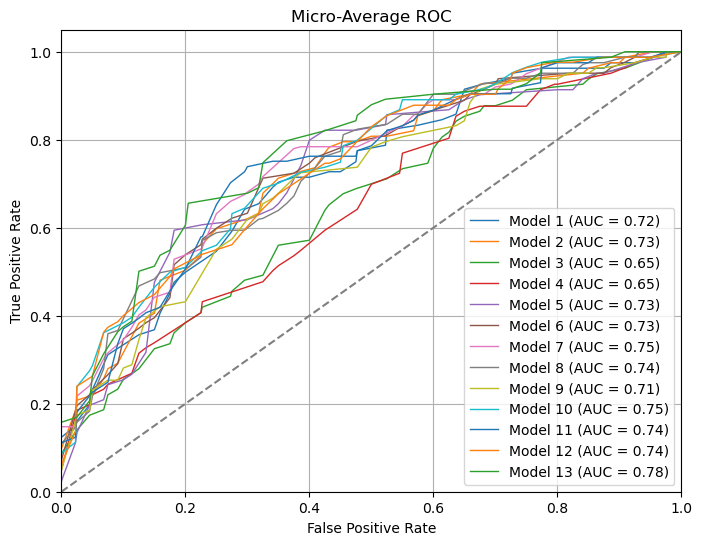

In [193]:
plt.figure(figsize=(8, 6))

for i, y_pred_probabilities in enumerate(probas):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    n_classes = len(class_labels) 
    for j in range(n_classes):
        y_true_class = (y_true_encoded == j).astype(int)
        fpr[j], tpr[j], _ = roc_curve(y_true_class, y_pred_probabilities[:, j])
        roc_auc[j] = auc(fpr[j], tpr[j])

    all_fpr = np.unique(np.concatenate([fpr[j] for j in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)

    for j in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[j], tpr[j])

    mean_tpr /= n_classes
    roc_auc_micro = auc(all_fpr, mean_tpr)

    plt.plot(all_fpr, mean_tpr, lw=1, label=f'Model {i+1} (AUC = {roc_auc_micro:.2f})')


plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-Average ROC')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


## Bag Of Words

In [206]:
word_counts = {}

for noticia in data[data['Category'].isin(['Compra'])]['Text'].to_list():
    tokens = noticia.split()
    
    for palabra in tokens:
        palabra = palabra.strip(".,!?()").lower()
        if palabra not in stopwords_custom:
            if palabra in word_counts:
                word_counts[palabra] += 1
            else:
                word_counts[palabra] = 1
                
word_counts = dict(sorted(word_counts.items(), key=lambda x: x[1], reverse=True))

## Power Words

In [207]:
prob_ensemble['CompraIndex'] = 0

for index, noticia in enumerate(prob_ensemble['X_test']):
    tokens = noticia.split()
    
    for palabra in tokens:
        palabra = palabra.strip(".,!?()").lower()
        if palabra in powerWords:
            prob_ensemble.loc[index, 'CompraIndex'] += 0.1

In [208]:
prob_ensemble

,X_test,y_test,Compra,Neutro,Ensemble Label,CompraIndex
0,Vaca Muerta's Sweet Crude Attracts Global Ener...,Compra,0.701828,0.298172,Compra,0.4
1,Is YPF SA (YPF) a Smart Choice in Oil & Gas In...,Neutro,0.622399,0.377601,Compra,0.0
2,Mexico's Pemex the biggest liquidity worry amo...,Neutro,0.329311,0.670689,Neutro,0.1
3,Argentina Fixes Oil at $56 a Barrel to Put Lid...,Neutro,0.550057,0.449943,Compra,0.0
4,Argentina to freeze crude price at $56/bbl to ...,Neutro,0.576057,0.423943,Compra,0.0
...,...,...,...,...,...,...
79,The 5 Latin American Countries With The Larges...,Compra,0.366336,0.633664,Neutro,0.6
80,\nYPF Sociedad Anonima (YPF) Dips More Than B...,Neutro,0.809348,0.190652,Compra,0.2
81,Could Argentina Replicate Brazil’s Offshore Oi...,Compra,0.690723,0.309277,Compra,0.5
82,\nIs Weatherford International (WFRD) Stock O...,Neutro,0.270924,0.729076,Neutro,0.0


In [246]:
# Si CompraIndex > 0.2 entonces cambiar el label a Compra
def CheckPowerWord(row):
    if row['CompraIndex'] >= 0.5 and row['Ensemble Label'] == 'Neutro':
        return 'Compra'
    else:
        return row['Ensemble Label']

prob_ensemble["PowerLabel"] = prob_ensemble.apply(CheckPowerWord, axis=1)

In [247]:
prob_ensemble

,X_test,y_test,Compra,Neutro,Ensemble Label,CompraIndex,PowerLabel
0,Vaca Muerta's Sweet Crude Attracts Global Ener...,Compra,0.701828,0.298172,Compra,0.4,Compra
1,Is YPF SA (YPF) a Smart Choice in Oil & Gas In...,Neutro,0.622399,0.377601,Compra,0.0,Compra
2,Mexico's Pemex the biggest liquidity worry amo...,Neutro,0.329311,0.670689,Neutro,0.1,Neutro
3,Argentina Fixes Oil at $56 a Barrel to Put Lid...,Neutro,0.550057,0.449943,Compra,0.0,Compra
4,Argentina to freeze crude price at $56/bbl to ...,Neutro,0.576057,0.423943,Compra,0.0,Compra
...,...,...,...,...,...,...,...
79,The 5 Latin American Countries With The Larges...,Compra,0.366336,0.633664,Neutro,0.6,Compra
80,\nYPF Sociedad Anonima (YPF) Dips More Than B...,Neutro,0.809348,0.190652,Compra,0.2,Compra
81,Could Argentina Replicate Brazil’s Offshore Oi...,Compra,0.690723,0.309277,Compra,0.5,Compra
82,\nIs Weatherford International (WFRD) Stock O...,Neutro,0.270924,0.729076,Neutro,0.0,Neutro


In [248]:
print("Accuracy: {:.2f}%".format(accuracy_score(y_test, prob_ensemble["Ensemble Label"].to_list()) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(y_test, prob_ensemble["Ensemble Label"].to_list(), average='weighted') * 100))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, prob_ensemble["Ensemble Label"].to_list()))

Accuracy: 72.62%

F1 Score: 72.44

Confusion Matrix:
 [[35  9]
 [14 26]]


In [249]:
print("Accuracy: {:.2f}%".format(accuracy_score(y_test, prob_ensemble["PowerLabel"].to_list()) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(y_test, prob_ensemble["PowerLabel"].to_list(), average='weighted') * 100))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, prob_ensemble["PowerLabel"].to_list()))

Accuracy: 77.38%

F1 Score: 77.00

Confusion Matrix:
 [[39  5]
 [14 26]]


In [250]:
prob_ensemble.to_excel('ypf_predicciones_ensemble_power_v1.xlsx', index=False)

## Web Scraping

In [157]:
import requests
 
response = requests.get(url="https://quote-feed.zacks.com/index.php?t=YPF")
data = response.json()
data

{'YPF': {'source': {'sungard': {'bidasksize': '200x100',
    'dividend_freq': '1',
    'prev_close_date': '09/13/2023 16:00:02',
    'zacks_recommendation': '',
    'timestamp': '16:02',
    'exchange': 'NYSE',
    'shares': '',
    'volatility': '1.56',
    'pos_size': '51935',
    'open': '12.5',
    'yrlow': '5.99',
    'type': 'S',
    'yield': '0',
    'market_cap': '5050136262',
    'ask': '12.88',
    'dividend': '.14',
    'dividend_date': '07/18/2019 00:00:00',
    'earnings': '4.68',
    'close': '12.45',
    'day_low': '12.35',
    'last_trade_datetime': '09/13/2023 16:00:02',
    'volume': '2637803',
    'yrhigh': '16.19',
    'day_high': '12.88',
    'bid': '12.74',
    'name': 'YPF Sociedad Anonima',
    'pe_ratio': '3',
    'updated': '09/13/2023 16:00:02'},
   'bats': {'ask_size': '646',
    'routed': '5239',
    'last_trade_datetime': '09/13/2023 15:58:02',
    'matched': '85758',
    'bid_size': '5',
    'net_pct_change': '0',
    'updated': '09/13/2023 15:58:05',
   